# Hi-C Simulation: Modeling the Active Region Geometry
Our first task is to model the active region geometry. We need to download the magnetogram from 29 May 2018 17:00:00 UTC (1 PM Eastern) and perform a field extrapolation. I determined the approximate time of the launch from [this tweet from Amy Winebarger](https://twitter.com/AmyRWinebarger/status/1001540531099402240).

In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord
import astropy.time
from sunpy.sun import constants
from sunpy.map import Map,GenericMap
from sunpy.net import Fido,attrs as a,vso
from sunpy.time import TimeRange
import sunpy.coordinates
from sunpy.util.metadata import MetaDict

import synthesizAR
import synthesizAR.extrapolate

%matplotlib inline

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Downloading the Data
The first step is to pull down the HMI magnetogram from JSOC.

In [2]:
q = Fido.search(a.Time(TimeRange('2018/05/29 16:59:30', '2018/05/29 17:00:30')),
                a.Instrument('HMI'), vso.attrs.Physobs('LOS_magnetic_field'))
file_path = Fido.fetch(q,)
magnetogram = Map(file_path)

[                                        ========================================


In [2]:
# or use the already-downloaded file
magnetogram = Map('/storage-home/w/wtb2/sunpy/data/hmi_m_45s_2018_05_29_17_00_45_tai_magnetogram.fits')

We rotate the magnetogram such that the pixel and physical dimensions are properly aligned. For some reason, the HMI data is delivered from JSOC rotated by 180$^{\circ}$

In [3]:
magnetogram = magnetogram.rotate(order=3)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,


/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


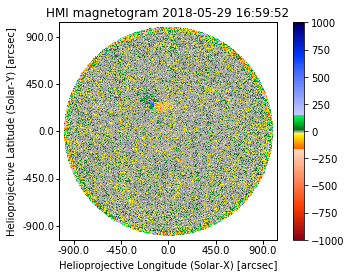

In [4]:
magnetogram.peek(vmin=-1e3,vmax=1e3,cmap='hmimag')
plt.show()

In [5]:
blc = SkyCoord(-375*u.arcsec, 50*u.arcsec, frame=magnetogram.coordinate_frame)
trc = SkyCoord(100*u.arcsec, 450*u.arcsec, frame=magnetogram.coordinate_frame)

In [6]:
magnetogram_ar = magnetogram.submap(blc,trc)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


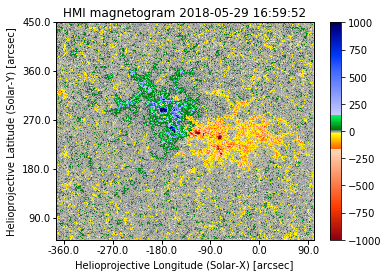

In [7]:
magnetogram_ar.peek(vmin=-1e3,vmax=1e3,cmap='hmimag')
plt.show()

In [8]:
magnetogram_ar_resampled = magnetogram_ar.resample([125,125]*u.pixel)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


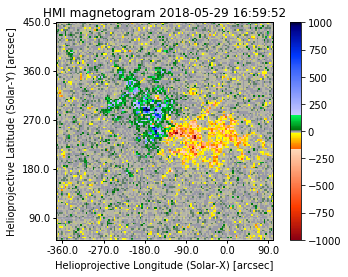

In [9]:
magnetogram_ar_resampled.peek(vmin=-1e3,vmax=1e3,cmap='hmimag')
plt.show()

## Extrapolating the Field

In [10]:
shape_z = 125*u.pixel
width_z = 0.3 * const.R_sun
extrapolator = synthesizAR.extrapolate.PotentialField(magnetogram_ar_resampled,width_z,shape_z)
B_field = extrapolator.extrapolate()

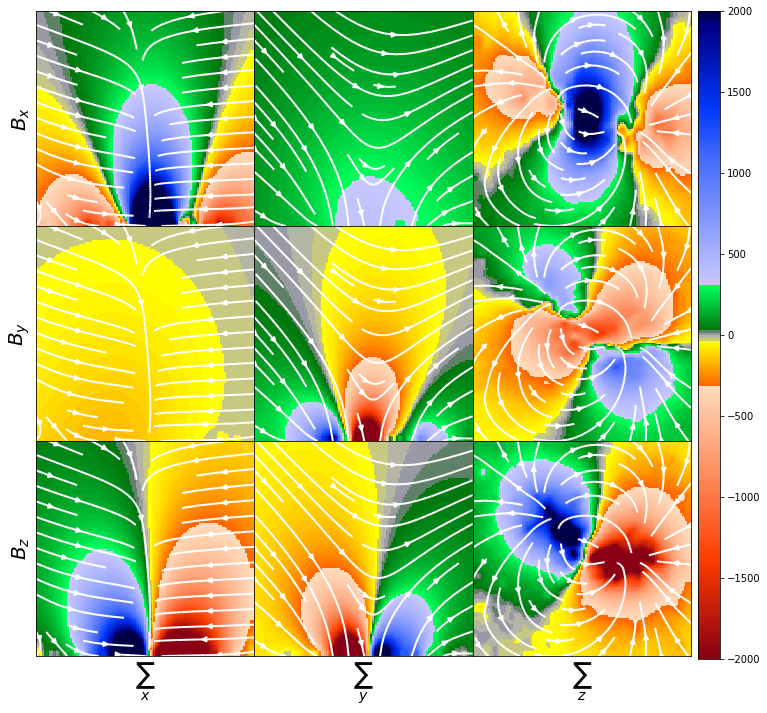

In [11]:
synthesizAR.extrapolate.peek_projections(B_field)

## Tracing Fieldlines
Trace 500 lines from the positive and 500 from the negative field for a total of 1000 lines. We try to choose those line which are rooted in the strongest field.

In [16]:
fieldlines_pos = extrapolator.trace_fieldlines(B_field,
                                               1000,
                                               close_threshold=0.05,
                                               mask_threshold=0.15,
                                               direction=1,
                                               loop_length_range=[30,500]*u.Mm)

yt : [INFO     ] 2018-06-29 16:20:56,292 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-06-29 16:20:56,293 Parameters: domain_dimensions         = [125 125 125]
yt : [INFO     ] 2018-06-29 16:20:56,294 Parameters: domain_left_edge          = [-1.75979134e+10 -1.41161768e+10  0.00000000e+00]
yt : [INFO     ] 2018-06-29 16:20:56,295 Parameters: domain_right_edge         = [1.64104435e+10 1.62472452e+10 2.08710000e+10]
yt : [INFO     ] 2018-06-29 16:20:56,295 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2018-06-29 16:20:57,785 AMRKDTree rebuilt, Final Volume: 2.155161e+31
Streamlining: 100%|██████████| 1000/1000 [00:03<00:00, 252.83it/s]
yt : [INFO     ] 2018-06-29 16:21:02,906 AMRKDTree rebuilt, Final Volume: 2.155161e+31
Streamlining: 100%|██████████| 352/352 [00:01<00:00, 323.70it/s]
yt : [INFO     ] 2018-06-29 16:21:05,240 AMRKDTree rebuilt, Final Volume: 2.155161e+31
Streamlining: 100%|██████████| 108/108 [00:00<00:00, 311.00it/s]
yt : [INFO     ] 2

FloatProgress(value=0.0)

In [17]:
fieldlines_neg = extrapolator.trace_fieldlines(B_field,
                                               1000,
                                               close_threshold=0.05,
                                               mask_threshold=-0.15,
                                               direction=-1,
                                               loop_length_range=[30,500]*u.Mm)

yt : [INFO     ] 2018-06-29 16:22:37,884 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-06-29 16:22:37,885 Parameters: domain_dimensions         = [125 125 125]
yt : [INFO     ] 2018-06-29 16:22:37,885 Parameters: domain_left_edge          = [-1.75979134e+10 -1.41161768e+10  0.00000000e+00]
yt : [INFO     ] 2018-06-29 16:22:37,886 Parameters: domain_right_edge         = [1.64104435e+10 1.62472452e+10 2.08710000e+10]
yt : [INFO     ] 2018-06-29 16:22:37,886 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2018-06-29 16:22:39,285 AMRKDTree rebuilt, Final Volume: 2.155161e+31
Streamlining: 100%|██████████| 1000/1000 [00:03<00:00, 251.50it/s]
yt : [INFO     ] 2018-06-29 16:22:45,155 AMRKDTree rebuilt, Final Volume: 2.155161e+31
Streamlining: 100%|██████████| 365/365 [00:01<00:00, 260.32it/s]
yt : [INFO     ] 2018-06-29 16:22:48,076 AMRKDTree rebuilt, Final Volume: 2.155161e+31
Streamlining: 100%|██████████| 155/155 [00:00<00:00, 274.27it/s]
yt : [INFO     ] 2

FloatProgress(value=0.0)

In [18]:
fieldlines = fieldlines_pos + fieldlines_neg

In [19]:
active_region = synthesizAR.Field(magnetogram_ar_resampled,fieldlines)

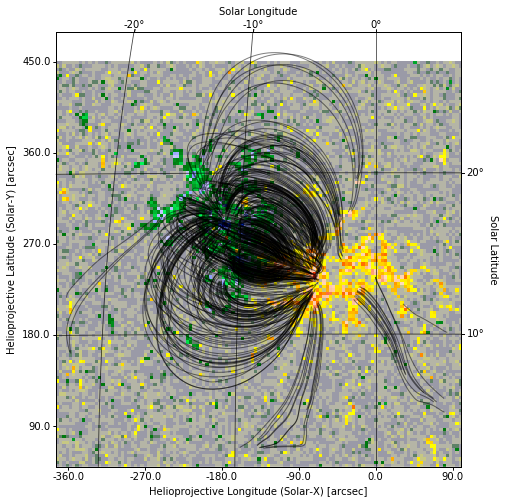

In [22]:
active_region.peek(line_frequency=4)

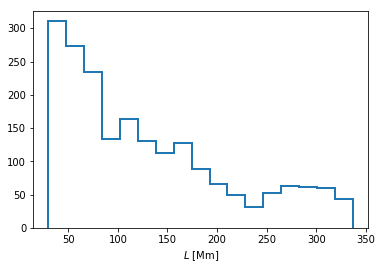

In [23]:
loop_lengths = u.Quantity([l.full_length.to(u.Mm).value for l in active_region.loops], 'Mm')
plt.hist(loop_lengths,bins='fd',histtype='step',lw=2);
plt.xlabel('$L$ [Mm]');

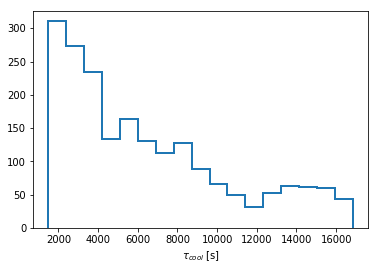

In [24]:
plt.hist(loop_lengths / (80*u.Mm) * 4000*u.s,bins='fd',histtype='step',lw=2);
plt.xlabel(r'$\tau_{cool}$ [s]');

When we load the hydrodynamic results in, we will need to reinterpolate the loop coordinates to the appropriate resolution as determined by the uniform grid output files.

In [25]:
active_region.save('/storage-home/w/wtb2/data/hi_c_simulation/noaa12712_base')